# 1. Setup and data load

## 1.1 Libraries

In [1]:
import pickle
import joblib
import numpy as np
import pandas as pd

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    log_loss,
    brier_score_loss,
    confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")
sns.set()


In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, log_loss, confusion_matrix, classification_report)
from sklearn.model_selection import learning_curve,  cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
import optuna
from optuna.samplers import TPESampler
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

c:\Users\Office\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1.2 Load preprocessed data

In [3]:
# BASELINE features
with open("./outputs/processed/baseline_preprocessed.pkl", "rb") as f:
    baseline_data = pickle.load(f)

X_train_basic = baseline_data["X_train"]
X_val_basic   = baseline_data["X_val"]
X_test_basic  = baseline_data["X_test"]
y_train_basic = baseline_data["y_train"]
y_val_basic   = baseline_data["y_val"]
y_test_basic  = baseline_data["y_test"]

# EXTENDED features
with open("./outputs/processed/extended_preprocessed.pkl", "rb") as f:
    extended_data = pickle.load(f)

X_train_ext = extended_data["X_train"]
X_val_ext   = extended_data["X_val"]
X_test_ext  = extended_data["X_test"]
y_train_ext = extended_data["y_train"]
y_val_ext   = extended_data["y_val"]
y_test_ext  = extended_data["y_test"]


## 1.3 Load trained models

In [5]:
# Random Forest: baseline & extended
rf_baseline_res = joblib.load("./outputs/models/baseline_rf_results.pkl")
rf_extended_res = joblib.load("./outputs/models/extended_rf_results.pkl")

rf_baseline_best = rf_baseline_res["best_model"]
rf_extended_best = rf_extended_res["best_model"]

# XGBoost: baseline & extended
xgb_baseline_res = joblib.load("./outputs/models/xgboost_best_model.pkl")
xgb_extended_res = joblib.load("./outputs/models/xgboost_extended_results.pkl")

xgb_baseline_best = xgb_baseline_res["best_model"]
xgb_extended_best = xgb_extended_res["best_model"]


ModuleNotFoundError: No module named 'xgboost'

# 2 Overall model comparison

In [9]:
models = {
    "RF Baseline":  (rf_baseline_best,  X_test_basic, y_test_basic),
   # "XGB Baseline": (xgb_baseline_best, X_test_basic, y_test_basic),
    "RF Extended":  (rf_extended_best,  X_test_ext,   y_test_ext),
   # "XGB Extended": (xgb_extended_best, X_test_ext,   y_test_ext),
}

rows = []

for name, (model, X_test, y_test) in models.items():
    # assuming predict_proba is available
    proba = model.predict_proba(X_test)[:, 1]
    y_pred = (proba >= 0.5).astype(int)

    rows.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC_AUC": roc_auc_score(y_test, proba),
        "LogLoss": log_loss(y_test, proba),
        "Brier": brier_score_loss(y_test, proba),
    })

metrics_df = pd.DataFrame(rows)
metrics_df


,Model,Accuracy,Precision,Recall,F1,ROC_AUC,LogLoss,Brier
0,RF Baseline,0.551129,0.562125,0.518262,0.539303,0.569282,0.685053,0.246005
1,RF Extended,0.577220,0.589874,0.544826,0.566456,0.602984,0.675739,0.241465


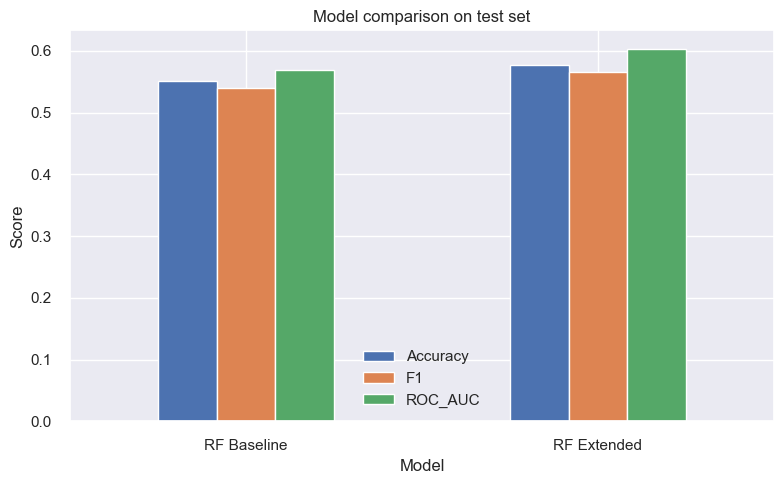

In [10]:
fig, ax = plt.subplots(figsize=(8, 5))

metrics_to_show = ["Accuracy", "F1", "ROC_AUC"]
subset = metrics_df.set_index("Model")[metrics_to_show]

subset.plot(kind="bar", ax=ax)
ax.set_title("Model comparison on test set")
ax.set_ylabel("Score")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


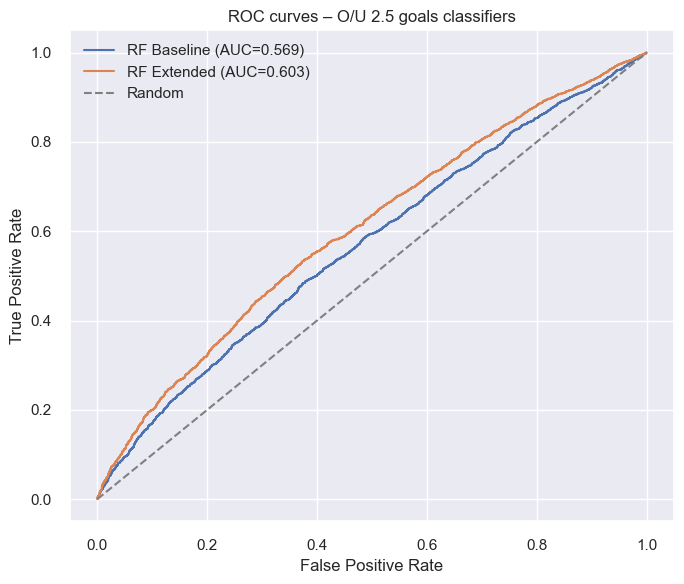

In [11]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(7, 6))

for name, (model, X_test, y_test) in models.items():
    proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0, 1], [0, 1], "--", color="gray", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves – O/U 2.5 goals classifiers")
plt.legend()
plt.tight_layout()
plt.show()


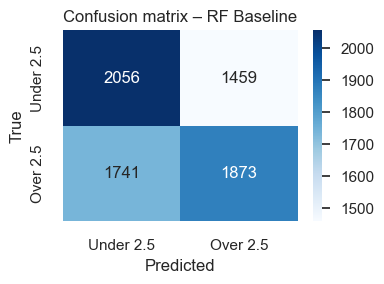

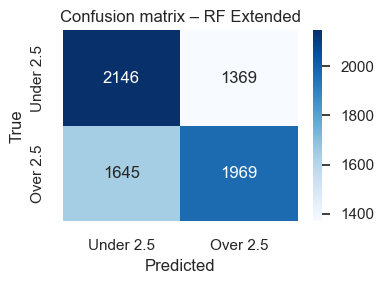

In [12]:
def plot_cm(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Under 2.5", "Over 2.5"],
                yticklabels=["Under 2.5", "Over 2.5"])
    plt.title(f"Confusion matrix – {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

for name, (model, X_test, y_test) in models.items():
    plot_cm(name, model, X_test, y_test)


# 3 Model comparison by countries